# <div dir = 'rtl'>کتابخانه های لازم</div>

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# <div dir = 'rtl'>فراخوانی داده ها</div>

In [7]:
import ccxt
import pandas as pd
import datetime

# اتصال به بایننس
exchange = ccxt.binance()

# تبدیل تاریخ به timestamp
since = exchange.parse8601("2015-01-01T00:00:00Z")
until = exchange.parse8601("2023-01-01T00:00:00Z")

# گرفتن داده های کندل 1 روزه
ohlcv = []
limit = 1000
symbol = 'BTC/USDT'   # بایننس جفت USDT داره

while since < until:
    candles = exchange.fetch_ohlcv(symbol, timeframe='1d', since=since, limit=limit)
    if not candles:
        break
    ohlcv += candles
    since = candles[-1][0] + 24*60*60*1000  # رفتن به روز بعد

# ساخت دیتافریم
data = pd.DataFrame(ohlcv, columns=['Timestamp','Open','High','Low','Close','Volume'])
data['Date'] = pd.to_datetime(data['Timestamp'], unit='ms')
data = data.set_index('Date')
data = data[['Open','High','Low','Close','Volume']]

print(data.head())
print(data.tail())


               Open     High      Low    Close       Volume
Date                                                       
2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377
2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264
2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763
2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022
2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060
                Open      High       Low     Close        Volume
Date                                                            
2023-02-02  23731.41  24255.00  23363.27  23488.94  364177.20751
2023-02-03  23489.33  23715.70  23204.62  23431.90  332571.02904
2023-02-04  23431.90  23587.78  23253.96  23326.84  166126.47295
2023-02-05  23327.66  23433.33  22743.00  22932.91  209251.33917
2023-02-06  22932.91  23158.25  22628.13  22762.52  265371.60690


# <div dir = 'rtl'> بررسی متغیر پاسخ </div>

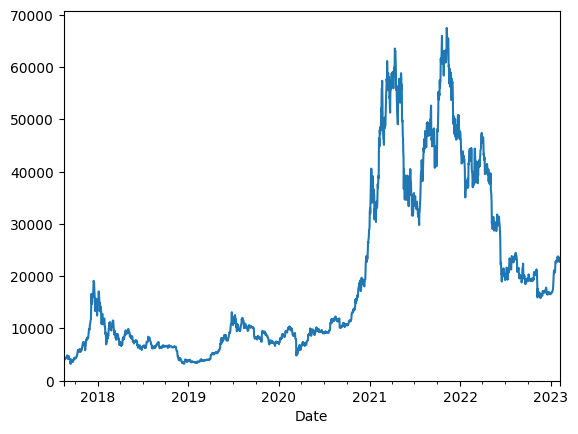

In [8]:
data['Close'].plot();

# <div dir = 'rtl'>استاندارد کردن داده ها برای تحلیل</div>

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# <div dir = 'rtl'> ساخت دنباله برای تحلیل </div>

In [10]:
def create_sequences(data, target_idx, time_steps=60):
    """
    داده ورودی: آرایه 2D شامل تمام متغیرها
    target_idx: اندیس ستون هدف (Close)
    """
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])  
        y.append(data[i, target_idx])      
    return np.array(X), np.array(y)

time_steps = 60
target_idx = 3  
X, y = create_sequences(scaled_data, target_idx, time_steps)

# <div dir = 'rtl'>تقسیم داده ها </div>

In [11]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# <div dir = 'rtl'>طراحی مدل <code>LSTM</code></div>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(80, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
                              validation_split=0.1, verbose=1)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0186 - mae: 0.0744 - val_loss: 0.0089 - val_mae: 0.0733
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0024 - mae: 0.0277 - val_loss: 0.0079 - val_mae: 0.0754
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0025 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0594
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0018 - mae: 0.0245 - val_loss: 0.0042 - val_mae: 0.0515
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0020 - mae: 0.0248 - val_loss: 0.0074 - val_mae: 0.0683
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0020 - mae: 0.0281 - val_loss: 0.0068 - val_mae: 0.0656
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0022 - mae: 0.0266 - val_loss: 0.0031 - val_mae: 0.0468
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0019 - mae: 0.0259 - val_loss: 0.0028 - val_mae: 0.0437
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.001

# <div dir = 'rtl'>رسم نمودار مقادیر واقعی در برابر پیش بینی </div>

# <div dir = 'rtl'>رسم نمودار <code>Training Loss</code> در برابر <code>Validation Loss</code></div>

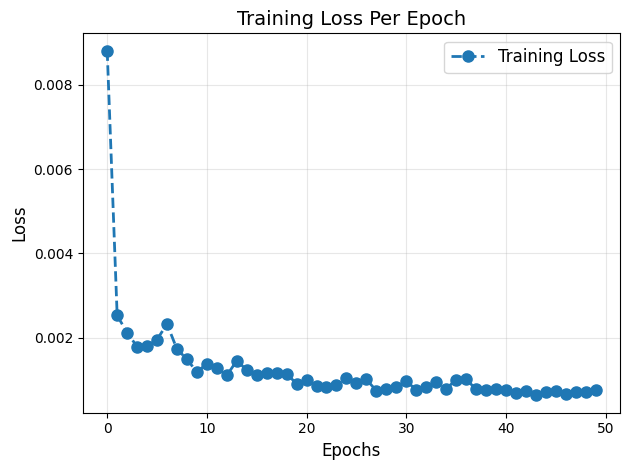

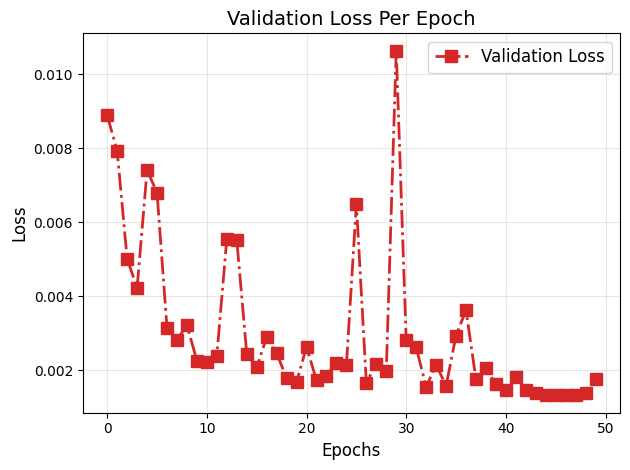

In [23]:
plt.style.use('seaborn-v0_8-deep') 
plt.figure()
plt.plot(history_lstm.history['loss'], color='#1f77b4', linestyle='--', linewidth=2, marker='o', markersize=8, label='Training Loss')
plt.title('Training Loss Per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.figure()
plt.plot(history_lstm.history['val_loss'], color='#d62728', linestyle='-.', linewidth=2, marker='s', markersize=8, label='Validation Loss')
plt.title('Validation Loss Per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

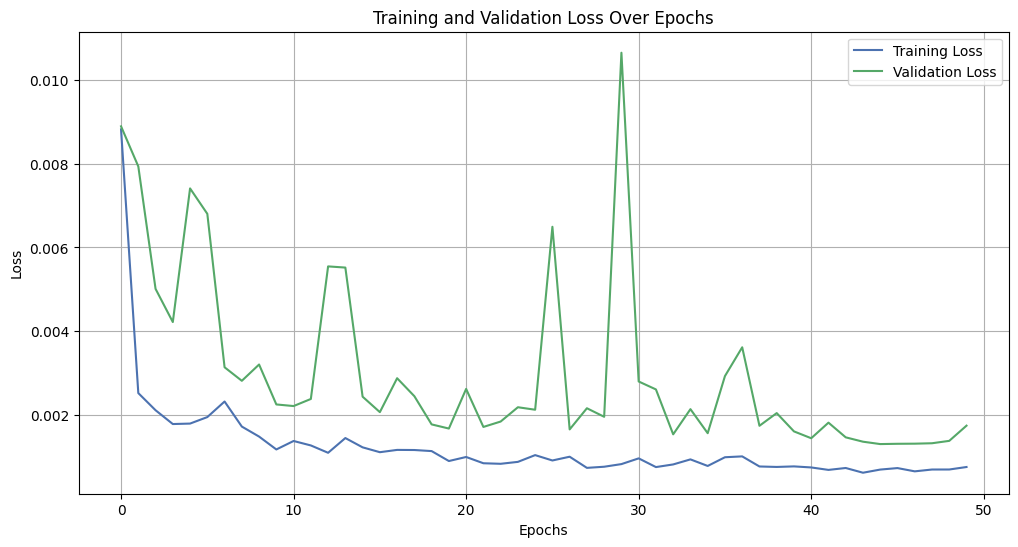

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
from tensorflow.keras.layers import GRU

def build_gru(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(80, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
history_gru = gru_model.fit(X_train, y_train, epochs=50, batch_size=32,
                            validation_split=0.1, verbose=1)


Epoch 1/50


c:\python\Sina\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0115 - mae: 0.0660 - val_loss: 0.0024 - val_mae: 0.0393
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0018 - mae: 0.0230 - val_loss: 0.0024 - val_mae: 0.0393
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0018 - mae: 0.0246 - val_loss: 0.0020 - val_mae: 0.0353
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0015 - mae: 0.0228 - val_loss: 0.0112 - val_mae: 0.0974
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0010 - mae: 0.0197 - val_loss: 0.0020 - val_mae: 0.0352
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013 - mae: 0.0205 - val_loss: 0.0029 - val_mae: 0.0440
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0015 - mae: 0.0240 - val_loss: 0.0022 - val_mae: 0.0381
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0018 - mae: 0.0245 - val_loss: 0.0036 - val_mae: 0.0512
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011 - mae: 0.

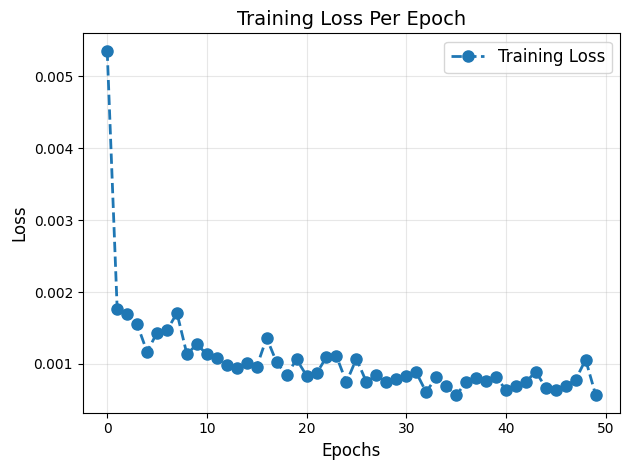

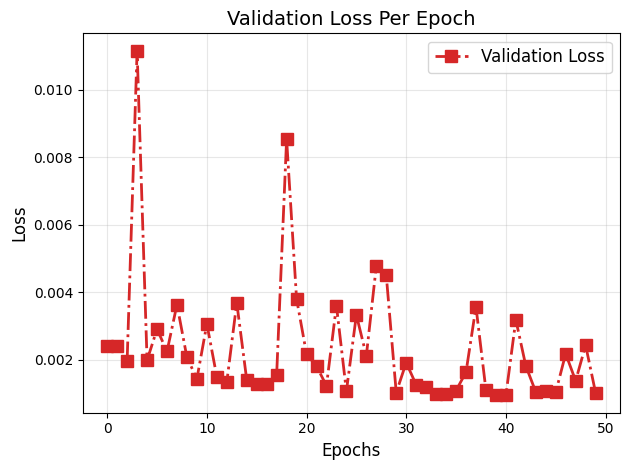

In [31]:
plt.style.use('seaborn-v0_8-deep') 
plt.figure()
plt.plot(history_gru.history['loss'], color='#1f77b4', linestyle='--', linewidth=2, marker='o', markersize=8, label='Training Loss')
plt.title('Training Loss Per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.figure()
plt.plot(history_gru.history['val_loss'], color='#d62728', linestyle='-.', linewidth=2, marker='s', markersize=8, label='Validation Loss')
plt.title('Validation Loss Per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

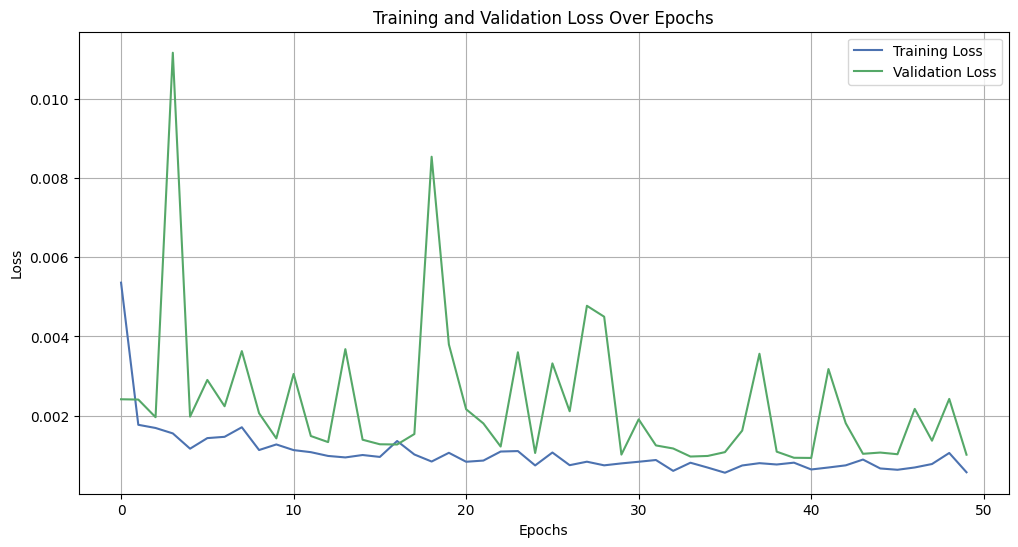

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from tensorflow.keras.layers import Bidirectional

def build_bilstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(80, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

bilstm_model = build_bilstm((X_train.shape[1], X_train.shape[2]))
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
                                  validation_split=0.1, verbose=1)


Epoch 1/50


c:\python\Sina\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0165 - mae: 0.0779 - val_loss: 0.0223 - val_mae: 0.1303
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0022 - mae: 0.0284 - val_loss: 0.0032 - val_mae: 0.0440
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0015 - mae: 0.0223 - val_loss: 0.0035 - val_mae: 0.0458
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012 - mae: 0.0200 - val_loss: 0.0104 - val_mae: 0.0912
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0016 - mae: 0.0238 - val_loss: 0.0030 - val_mae: 0.0452
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0014 - mae: 0.0215 - val_loss: 0.0022 - val_mae: 0.0372
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0013 - mae: 0.0217 - val_loss: 0.0048 - val_mae: 0.0593
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0016 - mae: 0.0235 - val_loss: 0.0027 - val_mae: 0.0411
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0010 - mae: 0.

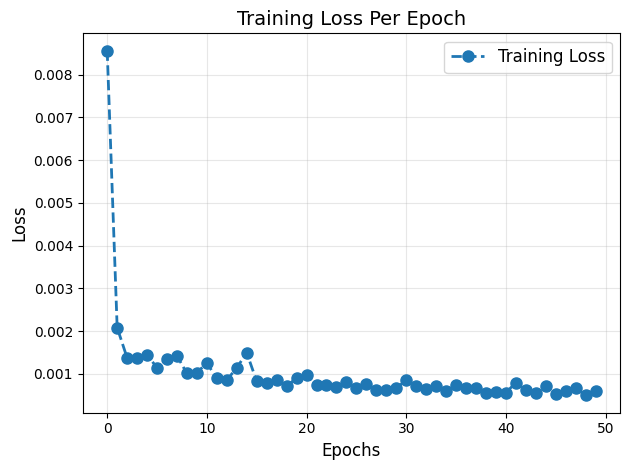

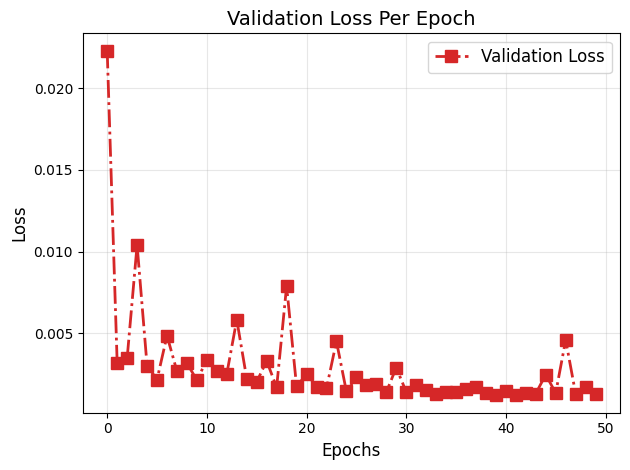

In [33]:
plt.style.use('seaborn-v0_8-deep') 
plt.figure()
plt.plot(history_bilstm.history['loss'], color='#1f77b4', linestyle='--', linewidth=2, marker='o', markersize=8, label='Training Loss')
plt.title('Training Loss Per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.figure()
plt.plot(history_bilstm.history['val_loss'], color='#d62728', linestyle='-.', linewidth=2, marker='s', markersize=8, label='Validation Loss')
plt.title('Validation Loss Per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

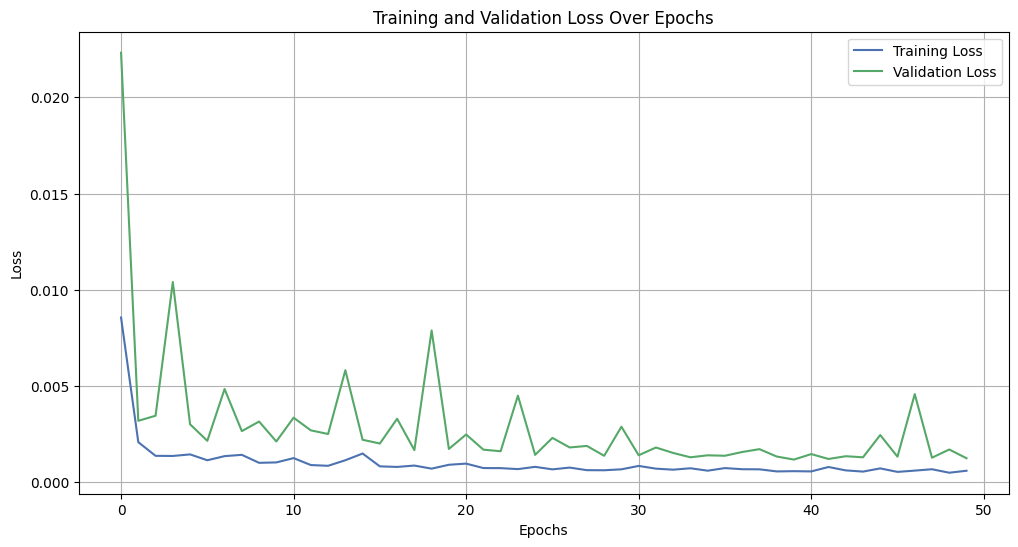

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test, scaler, target_idx=3):
    # پیش‌بینی
    y_pred = model.predict(X_test)
    
    # بازگرداندن مقیاس (inverse transform)
    y_test_scaled = np.zeros((len(y_test), scaler.n_features_in_))
    y_pred_scaled = np.zeros((len(y_pred), scaler.n_features_in_))

    y_test_scaled[:, target_idx] = y_test
    y_pred_scaled[:, target_idx] = y_pred[:,0]

    y_test_inv = scaler.inverse_transform(y_test_scaled)[:, target_idx]
    y_pred_inv = scaler.inverse_transform(y_pred_scaled)[:, target_idx]

    # محاسبه معیارها
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)

    return y_test_inv, y_pred_inv, mse, mae, rmse, r2


In [25]:
# LSTM
y_test_lstm, y_pred_lstm, mse_lstm, mae_lstm, rmse_lstm, r2_lstm = evaluate_model(lstm_model, X_test, y_test, scaler)

# GRU
y_test_gru, y_pred_gru, mse_gru, mae_gru, rmse_gru, r2_gru = evaluate_model(gru_model, X_test, y_test, scaler)

# BiLSTM
y_test_bilstm, y_pred_bilstm, mse_bilstm, mae_bilstm, rmse_bilstm, r2_bilstm = evaluate_model(bilstm_model, X_test, y_test, scaler)

# نمایش نتایج
results = pd.DataFrame({
    "Model": ["LSTM", "GRU", "BiLSTM"],
    "MSE": [mse_lstm, mse_gru, mse_bilstm],
    "MAE": [mae_lstm, mae_gru, mae_bilstm],
    "RMSE": [rmse_lstm, rmse_gru, rmse_bilstm],
    "R²": [r2_lstm, r2_gru, r2_bilstm]
})

print(results)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
    Model           MSE          MAE         RMSE        R²
0    LSTM  2.046826e+06  1003.829824  1430.673100  0.977941
1     GRU  1.234657e+06   745.094882  1111.151119  0.986694
2  BiLSTM  3.005885e+06  1389.777255  1733.748726  0.967605


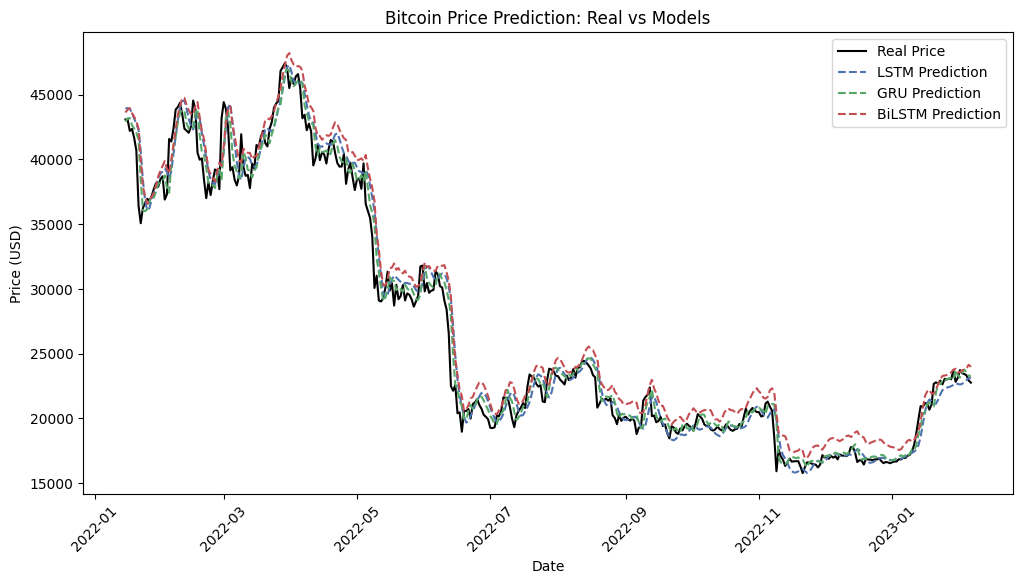

In [29]:
# تاریخ‌های بخش تست
test_dates = data.index[-len(y_test):]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_lstm, label="Real Price", color="black")
plt.plot(test_dates, y_pred_lstm, label="LSTM Prediction", linestyle="--")
plt.plot(test_dates, y_pred_gru, label="GRU Prediction", linestyle="--")
plt.plot(test_dates, y_pred_bilstm, label="BiLSTM Prediction", linestyle="--")

plt.title("Bitcoin Price Prediction: Real vs Models")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.xticks(rotation=45)  # تاریخ‌ها خواناتر بشن
plt.show()


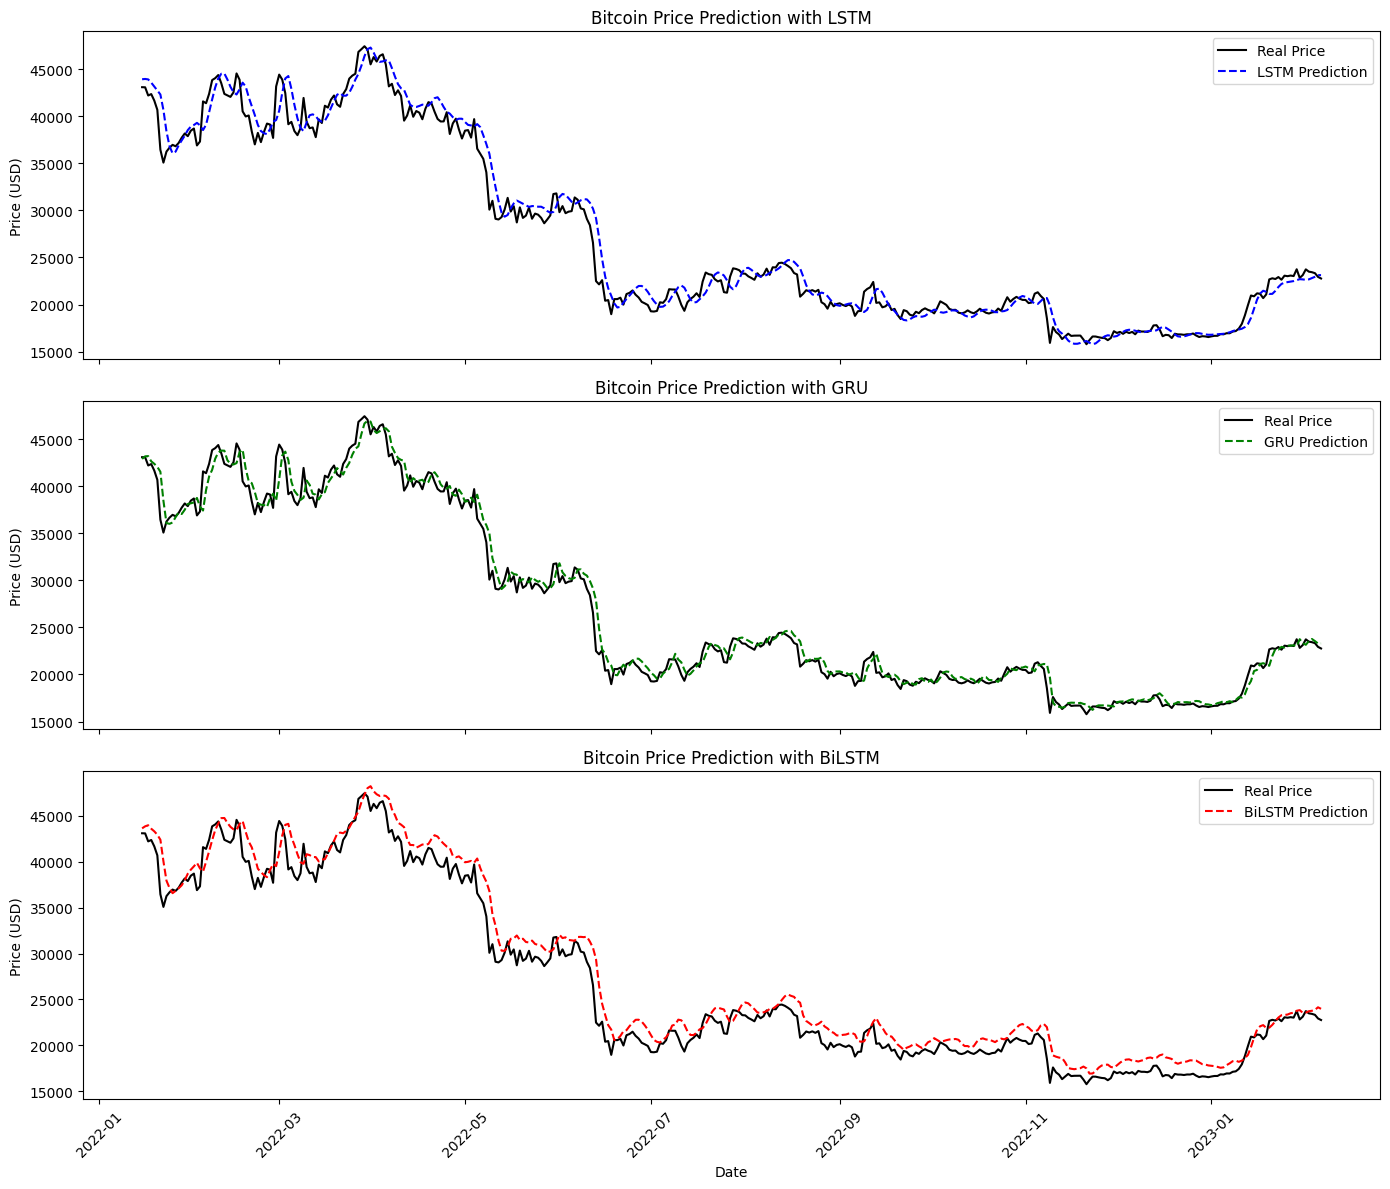

In [30]:
# تاریخ‌های بخش تست
test_dates = data.index[-len(y_test):]

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# --- LSTM ---
axes[0].plot(test_dates, y_test_lstm, label="Real Price", color="black")
axes[0].plot(test_dates, y_pred_lstm, label="LSTM Prediction", linestyle="--", color="blue")
axes[0].set_title("Bitcoin Price Prediction with LSTM")
axes[0].set_ylabel("Price (USD)")
axes[0].legend()

# --- GRU ---
axes[1].plot(test_dates, y_test_gru, label="Real Price", color="black")
axes[1].plot(test_dates, y_pred_gru, label="GRU Prediction", linestyle="--", color="green")
axes[1].set_title("Bitcoin Price Prediction with GRU")
axes[1].set_ylabel("Price (USD)")
axes[1].legend()

# --- BiLSTM ---
axes[2].plot(test_dates, y_test_bilstm, label="Real Price", color="black")
axes[2].plot(test_dates, y_pred_bilstm, label="BiLSTM Prediction", linestyle="--", color="red")
axes[2].set_title("Bitcoin Price Prediction with BiLSTM")
axes[2].set_ylabel("Price (USD)")
axes[2].set_xlabel("Date")
axes[2].legend()

# بهبود نمایش تاریخ‌ها
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
